In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, skew, spearmanr, pearsonr

#SMOTE
from imblearn.over_sampling import SMOTE

#Mô hình XG Boost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier

import joblib

In [3]:
#Có vẻ như dữ liệu đang có một số điểm bất thường, ta sẽ kiểm tra
data=pd.read_csv('/content/drive/MyDrive/Datasets/Order Data Prediction/Order-Data-Prediction-new.csv')

<ipython-input-3-cff3a156b5d0>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/content/drive/MyDrive/Datasets/Order Data Prediction/Order-Data-Prediction-new.csv')


In [4]:
#Loại đi giá trị bất thường này
data = data[~data['RELEASED_CREDIT_VALUE'].apply(lambda x: pd.to_numeric(x, errors='coerce')).isna()]
data

,SALES_ORG,DISTRIBUTION_CHANNEL,DIVISION,RELEASED_CREDIT_VALUE,PURCHASE_ORDER_TYPE,COMPANY_CODE,CREDIT_CONTROL_AREA,SOLD_TO_PARTY,CREDIT_STATUS,CUSTOMER_NUMBER,Processing days,amount_in_usd
0,3537,United States of America,South-Region,0.0,1000,3220,SR02,756141537,NaN,12311807,12,1021.4327
1,3449,Martinique,South-Region,0.0,1000,3220,NR03,798847812,NaN,12311807,10,842.4752
2,3238,Moldova,South-Region,82342.02,I200,3260,NR01,960984659,93.0,12118758,11,72218.0022
3,3911,United Arab Emirates,South-Region,1471.24,N000,3290,SR02,925857642,93.0,1210499770,5,1503.9278
4,2381,Greece,South-Region,0.0,N000,3290,SR01,947942786,64.0,1210351400,5,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
1059455,2498,Germany,South-Region,0.0,NaN,4260,NR02,946056501,NaN,1210331804,0,3267.2406
1059456,4509,Armenia,South-Region,0.0,NaN,4260,NR04,894775488,NaN,1210331804,0,0.0000
1059457,3951,Nepal,South-Region,0.0,NaN,4260,NR01,909729781,NaN,1210331811,0,0.0000
1059458,3235,Panama,South-Region,0.0,NaN,4260,SR04,940836817,NaN,1210331811,0,0.0000


In [5]:
data.loc['RELEASED_CREDIT_VALUE'] = data['RELEASED_CREDIT_VALUE'].astype(float)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1059460 entries, 0 to RELEASED_CREDIT_VALUE
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   SALES_ORG              1059459 non-null  float64
 1   DISTRIBUTION_CHANNEL   1059459 non-null  object 
 2   DIVISION               1059459 non-null  object 
 3   RELEASED_CREDIT_VALUE  1059459 non-null  object 
 4   PURCHASE_ORDER_TYPE    1044024 non-null  object 
 5   COMPANY_CODE           1059459 non-null  float64
 6   CREDIT_CONTROL_AREA    1059459 non-null  object 
 7   SOLD_TO_PARTY          1059459 non-null  float64
 8   CREDIT_STATUS          204731 non-null   float64
 9   CUSTOMER_NUMBER        1059459 non-null  float64
 10  Processing days        1059459 non-null  float64
 11  amount_in_usd          1059459 non-null  float64
dtypes: float64(7), object(5)
memory usage: 105.1+ MB


In [7]:
data = data.dropna()

In [8]:
data.describe()

,SALES_ORG,COMPANY_CODE,SOLD_TO_PARTY,CREDIT_STATUS,CUSTOMER_NUMBER,Processing days,amount_in_usd
count,202270.000000,202270.000000,2.022700e+05,202270.000000,2.022700e+05,202270.000000,2.022700e+05
mean,3305.804484,2924.881910,8.764336e+08,74.343081,1.024750e+09,12.935107,6.231629e+03
std,696.207373,991.340714,7.089548e+07,14.384066,4.491665e+08,148.076303,4.775122e+04
min,2100.000000,59.000000,7.534518e+08,52.000000,1.210001e+07,0.000000,0.000000e+00
25%,2701.000000,3000.000000,8.149249e+08,64.000000,1.210141e+09,3.000000,9.380000e+01
50%,3306.000000,3130.000000,8.764429e+08,64.000000,1.230010e+09,7.000000,3.209624e+02
75%,3910.000000,3350.000000,9.378894e+08,93.000000,1.230012e+09,12.000000,9.968653e+02
max,4510.000000,4260.000000,9.990074e+08,93.000000,1.230025e+09,65756.000000,3.363174e+06


In [9]:
#Một số giá trị trong 'Processing days' bất thường, ta nên xóa bớt:
data = data[data['Processing days'] <=200]

**FEARTURES SELECTION**

***Pearson Correlation***

In [10]:
pearson_cols = data.select_dtypes(include=['number']).columns
pearson_cols = pearson_cols.drop(['CREDIT_STATUS'])

for i in pearson_cols:
  corr, _ = pearsonr(data[i], data['CREDIT_STATUS'])
  print(f"Pearson Correlation of column {i}:", corr)

Pearson Correlation of column SALES_ORG: -0.0014203168515609665
Pearson Correlation of column COMPANY_CODE: -0.05426970199617342
Pearson Correlation of column SOLD_TO_PARTY: 0.0008393294947163961
Pearson Correlation of column CUSTOMER_NUMBER: -0.085867483790904
Pearson Correlation of column Processing days: 0.03600842051238157
Pearson Correlation of column amount_in_usd: 0.06561953953987582


***Chi-Squared cho các columns Object:***

In [11]:
obj_cols = data.select_dtypes(include=['object'])
remove_chi_ls=[]

for i in obj_cols.columns:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(obj_cols[i], data['CREDIT_STATUS']))
    print(i, '---', pval)
    if pval < 0.05:
      continue
    else:
      remove_chi_ls.append(i)
print(remove_chi_ls)

DISTRIBUTION_CHANNEL --- 0.6037766005777324
DIVISION --- 0.0
RELEASED_CREDIT_VALUE --- 0.0
PURCHASE_ORDER_TYPE --- 0.0
CREDIT_CONTROL_AREA --- 0.5648098160888673
['DISTRIBUTION_CHANNEL', 'CREDIT_CONTROL_AREA']


***Spearman Correlation***

In [12]:
spearman_cols = data.select_dtypes(include=['number']).columns
spearman_df = data[spearman_cols]
correlation_results = []

# Duyệt qua tất cả các cột trong DataFrame
for col in spearman_df.columns:
  if col == 'CREDIT_STATUS':
    continue
  else:
    if spearman_df[col].nunique() > 1:
      corr, p_value = spearmanr(spearman_df[col], spearman_df['CREDIT_STATUS'])
      correlation_results.append((col, corr, p_value))
    else:
        print(f"Cột {col} có giá trị không thay đổi và bị bỏ qua.")

# Chuyển kết quả thành DataFrame để dễ quan sát
correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Spearman Correlation', 'p-value'])
correlation_df = correlation_df.sort_values(by='Spearman Correlation', ascending=False)
correlation_df

,Feature,Spearman Correlation,p-value
1,COMPANY_CODE,0.237646,0.000000e+00
4,Processing days,0.186278,0.000000e+00
5,amount_in_usd,0.166892,0.000000e+00
2,SOLD_TO_PARTY,0.000799,7.195955e-01
0,SALES_ORG,-0.001422,5.229606e-01
3,CUSTOMER_NUMBER,-0.062239,2.644474e-172


In [13]:
#data = data.drop(columns = ['CUSTOMER_NUMBER', 'SALES_ORG', 'SOLD_TO_PARTY', 'DISTRIBUTION_CHANNEL', 'CREDIT_CONTROL_AREA'])
data = data.drop(columns = ['SALES_ORG', 'SOLD_TO_PARTY', 'DISTRIBUTION_CHANNEL', 'CREDIT_CONTROL_AREA'])

***ENCODING***

In [14]:
data

,DIVISION,RELEASED_CREDIT_VALUE,PURCHASE_ORDER_TYPE,COMPANY_CODE,CREDIT_STATUS,CUSTOMER_NUMBER,Processing days,amount_in_usd
2,South-Region,82342.02,I200,3260.0,93.0,1.211876e+07,11.0,72218.0022
3,South-Region,1471.24,N000,3290.0,93.0,1.210500e+09,5.0,1503.9278
4,South-Region,0.0,N000,3290.0,64.0,1.210351e+09,5.0,0.0000
5,South-Region,0.0,N250,3290.0,64.0,1.210124e+09,6.0,1139.9031
6,North-Region,0.0,NAAA,3470.0,64.0,1.231115e+07,4.0,324.0495
...,...,...,...,...,...,...,...,...
1059449,North-Region,0.0,9999,3000.0,64.0,1.210417e+09,0.0,866.7053
1059450,North-Region,0.0,9999,3000.0,64.0,1.230012e+09,7.0,26654.5296
1059451,North-Region,0.0,9999,3000.0,64.0,1.230012e+09,6.0,63748.3560
1059452,North-Region,0.0,9999,3000.0,64.0,1.230012e+09,7.0,44707.7868


In [15]:
PURCHASE_ORDER_TYPE_top_20 = data['PURCHASE_ORDER_TYPE'].value_counts().nlargest(20).index
data['PURCHASE_ORDER_TYPE'] = data['PURCHASE_ORDER_TYPE'].apply(lambda x: x if x in PURCHASE_ORDER_TYPE_top_20 else 'other')

In [16]:
columns_to_one_hot = ['DIVISION', 'PURCHASE_ORDER_TYPE', 'COMPANY_CODE']
data = pd.get_dummies(data, columns=columns_to_one_hot, drop_first=True)

In [17]:
label_encoders = {}
categorical_columns = data['CREDIT_STATUS']

le = LabelEncoder()
data.loc[:, 'CREDIT_STATUS'] = le.fit_transform(data['CREDIT_STATUS'])

**PREDICTION**

In [18]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(classification_report(y_test, y_pred))

In [19]:
#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(data, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = data.drop(columns=['CREDIT_STATUS'], axis=1)
    features = X.columns

    y = data['CREDIT_STATUS']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # MinMax Scaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = preprocess_data(data)

***1.Random Forest vs XG BOOST thuần túy***

In [21]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(objective='multi:softmax', num_class=3)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"Model: {model_name}")
    print_scores(y_train, y_train_pred)
    print_scores(y_test, y_test_pred)
    print('\n')

Model: RandomForest
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90      4562
         1.0       0.99      0.99      0.99     97336
         2.0       1.00      0.98      0.99     59502

    accuracy                           0.99    161400
   macro avg       0.94      0.99      0.96    161400
weighted avg       0.99      0.99      0.99    161400

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.82      1164
         1.0       0.99      0.99      0.99     24227
         2.0       0.98      0.97      0.98     14960

    accuracy                           0.98     40351
   macro avg       0.91      0.94      0.93     40351
weighted avg       0.98      0.98      0.98     40351



Model: XGBoost
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86      4562
         1.0       0.99      0.99      0.99     97336
         2.0       0.98      0.99     

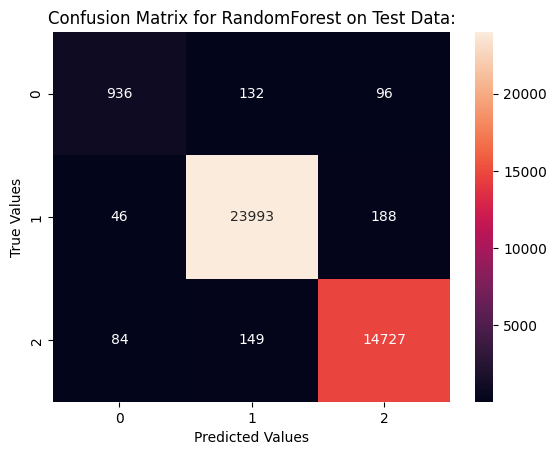

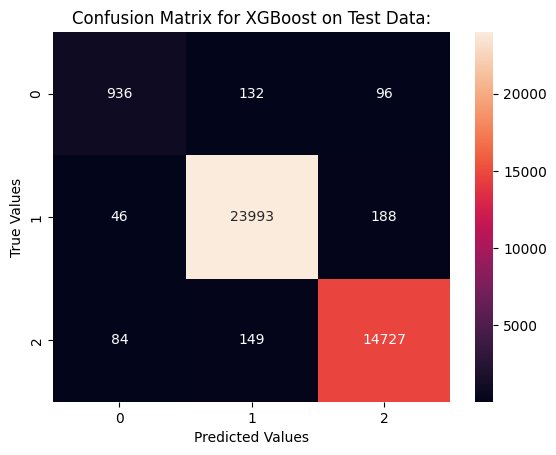

In [23]:
for model_name, model in models.items():
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(conf_matrix, xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"], annot=True, fmt="d")
    plt.title(f"Confusion Matrix for {model_name} on Test Data:")
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.show()

***2.SMOTE tích hợp XGBOOST***

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)
class_counts = y_train.value_counts()

smote = SMOTE(sampling_strategy={0: class_counts[1], 2: class_counts[1]}, random_state=42)

# Áp dụng SMOTE để tăng cường các lớp 0, 2, và 3
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [ ]:
model_XGB_2 = xgb.XGBClassifier(objective='multi:softmax',  num_class=3)
model_XGB_2.fit(X_train_resample, y_train_resample)

y_train_pred = model_XGB_2.predict(X_train_resample)
y_test_pred = model_XGB_2.predict(X_test)

print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     97336
         1.0       0.98      0.98      0.98     97336
         2.0       0.98      0.98      0.98     97336

    accuracy                           0.98    292008
   macro avg       0.98      0.98      0.98    292008
weighted avg       0.98      0.98      0.98    292008

              precision    recall  f1-score   support

         0.0       0.67      0.90      0.77      1164
         1.0       0.99      0.98      0.99     24227
         2.0       0.98      0.98      0.98     14960

    accuracy                           0.98     40351
   macro avg       0.88      0.95      0.91     40351
weighted avg       0.98      0.98      0.98     40351



***Cải thiện XGBOOST***

In [ ]:
param_grid = {
  'colsample_bytree': [0.3, 0.7],
  'learning_rate'   : [0.01, 0.1],
  'max_depth'       : [5, 8],
  'alpha'           : [1, 10],
  'n_estimators'    : [50, 100]
}

index = 0

answers_grid = {
    'combination'       :[],
    'train_Accuracy'    :[],
    'test_Accuracy'     :[],
    'colsample_bytree'  :[],
    'learning_rate'     :[],
    'max_depth'         :[],
    'alpha'             :[],
    'n_estimators'      :[]

    }

# Lặp qua tất cả các kết hợp của các siêu tham số
for colsample in param_grid['colsample_bytree']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            for alpha in param_grid['alpha']:
                for n_estimators in param_grid['n_estimators']:

                    # Tạo mô hình với các siêu tham số hiện tại
                    model_XGB_3 = xgb.XGBClassifier(
                        colsample_bytree=colsample,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        alpha=alpha,
                        n_estimators=n_estimators,
                        objective='multi:softmax', # Giả sử bài toán phân loại đa lớp
                        num_class=3 # Điều chỉnh cho phù hợp với số lớp của bạn
                    )

                    # Huấn luyện mô hình
                    model_XGB_3.fit(X_train_resample, y_train_resample)

                    # Đánh giá mô hình trên tập huấn luyện và tập kiểm tra
                    train_accuracy = model_XGB_3.score(X_train_resample, y_train_resample)
                    test_accuracy = model_XGB_3.score(X_test, y_test)

                    y_train_pred = model_XGB_3.predict(X_train_resample)
                    y_test_pred = model_XGB_3.predict(X_test)

                    # Lưu kết quả vào từ điển
                    answers_grid['combination'].append(index)
                    answers_grid['train_Accuracy'].append(train_accuracy)
                    answers_grid['test_Accuracy'].append(test_accuracy)
                    answers_grid['colsample_bytree'].append(colsample)
                    answers_grid['learning_rate'].append(learning_rate)
                    answers_grid['max_depth'].append(max_depth)
                    answers_grid['alpha'].append(alpha)
                    answers_grid['n_estimators'].append(n_estimators)

                    index += 1

print_scores(y_train_resample, y_train_pred)
print_scores(y_test, y_test_pred)

# Chuyển từ điển kết quả thành DataFrame để dễ dàng phân tích
results_df = pd.DataFrame(answers_grid)
print(results_df)

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     97336
         1.0       0.97      0.98      0.97     97336
         2.0       0.96      0.98      0.97     97336

    accuracy                           0.97    292008
   macro avg       0.97      0.97      0.97    292008
weighted avg       0.97      0.97      0.97    292008

              precision    recall  f1-score   support

         0.0       0.66      0.90      0.76      1164
         1.0       0.99      0.98      0.99     24227
         2.0       0.98      0.98      0.98     14960

    accuracy                           0.97     40351
   macro avg       0.88      0.95      0.91     40351
weighted avg       0.98      0.97      0.98     40351

    combination  train_Accuracy  test_Accuracy  colsample_bytree  \
0             0        0.907078       0.950856               0.3   
1             1        0.908595       0.955515               0.3   
2             2        0.906393   